In [1]:
import csv, copy, gzip, pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2

%matplotlib inline

## Deriving the EM Equations

We can derive the equations for the Expectation-Maximization algorithm by starting with the multivariate Gaussian distribution:  
$p(x|\mu,\sum) = N(x|\mu,\sum) = \frac{exp(-\frac{1}{2}(x-\mu)^{T}\sum^{-1}(x-\mu))}{(2\pi)^{D/2}|\sum|^{\frac{1}{2}}}$  
and taking its log:  
$ln(p(x|\mu,\sum)) = -\frac{1}{2}ln(2\pi)-\frac{1}{2}ln|\sum|-\frac{1}{2}(x-\mu)^{T}\sum^{-1}(x-\mu)$  
We can then take the derivative of this log with respect to the parameters $\mu$ and $\sum$ and set them to 0 to get their maximum values:  
$\frac{d(ln(p(x|\mu,\sum)))}{d\mu} = 0 \rightarrow \mu_{k} = \sum_{n} p_{n,k}x^{(n)}/p_{k}$  
$\frac{d(ln(p(x|\mu,\sum)))}{d\sum} = 0 \rightarrow \sum_{k} = \sum_{n} p_{n,k}(x^{(n)}-\mu_{k})(x^{(n)}-\mu_{k})^{T}/p_{k}$  
This gives us our first two equations from the M-step.  The remaining equations follow directly from the model.

And so we arrive at our final EM Equations:  
E-step: We compute $p_{n,k}$ and $p_k$:  
$p_{n,k} = p(c_{k}|x^{(n)},\theta_{1:K})$  
$p_k = \sum_{n}p_{n,k}$  
M-step: For each class, we compute the updated mean $\mu_{k}$, covariance $\sum_{k}$, and class prior $p(c_{k})$:  
$\mu_{k} = \sum_{n} p_{n,k}x^{(n)}/p_{k}$  
$\sum_{k} = \sum_{n} p_{n,k}(x^{(n)}-\mu_{k})(x^{(n)}-\mu_{k})^{T}/p_{k}$  
$p(c_{k}) = p_{k}$

In [2]:
# in case I need this later: http://www.cse.iitm.ac.in/~vplab/courses/DVP/PDF/gmm.pdf

## Loading the Data

In [3]:
# TODO: find better data
with open('data/faithful.txt', 'rt') as csvfile:
    dataReader = csv.reader(csvfile, delimiter=' ')
    # initialize an empty array
    data = []
    for row in dataReader:
        data.append(np.array(row).astype(np.float))
    # convert data into a numpy array
    data = np.asarray(data)

## Initializing the Mixture Model

In [4]:
ngmm = 2 # quantity of Gaussian Mixture Model
mu = np.asarray([[2, 70], 
                 [4, 80]]
               ).astype('float')

sigma = np.asarray([[[1, 0], 
                     [0, 3]], 
                    [[0.5, 0.2], 
                     [0.2, 0.6]]]
                  ).astype('float')
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print("Convariance Matrices are Legal? : %r" % covmatIsLegal(sigma))
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

Convariance Matrices are Legal? : True


## Plotting the Mixture Model

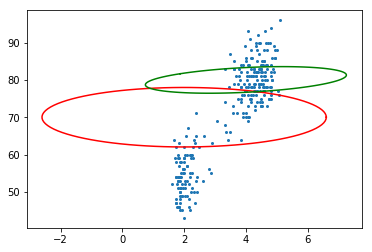

In [5]:
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

gmmplot(data, gmm)

## Optimizing the Mixture Model with the EM Algorithm

The basic idea of optimization process here is iteratively run **expectation** and **maximization**, and stop when the stop criteria is achived. Here, we use predefined number of iterations, **but we recommend you extend it into more comprehensive ones**. Also remember to show the progress of optimization with help of **gmmplot**.

[array([ 3.51344347, 69.61500462]), array([ 4.31924216, 80.50722704])]
[array([ 3.61428716, 70.39327417]), array([ 4.31174415, 81.05588311])]
[array([ 3.7516084 , 71.43790051]), array([ 4.30039221, 81.33117439])]
[array([ 3.8765392 , 72.67909154]), array([ 4.31998521, 81.99307812])]
[array([ 3.97534578, 73.6395927 ]), array([ 4.32532643, 82.48407676])]
[array([ 4.04215909, 74.2950403 ]), array([ 4.33429199, 82.79145275])]
[array([ 4.10474429, 74.79883655]), array([ 4.31809892, 83.02310874])]
[array([ 4.12715602, 75.13656533]), array([ 4.31225833, 83.17845834])]
[array([ 4.15064041, 75.34800029]), array([ 4.31983493, 83.29612447])]
[array([ 4.1745623, 75.5636793]), array([ 4.3339868 , 83.49572209])]
[array([ 4.19030684, 75.8202173 ]), array([ 4.33826007, 83.78587329])]
[array([ 4.19770187, 76.11315417]), array([ 4.34578838, 84.06277351])]
[array([ 4.20058359, 76.24887753]), array([ 4.35198424, 84.19934189])]
[array([ 4.2032737 , 76.30798945]), array([ 4.35327233, 84.27592378])]
[array([

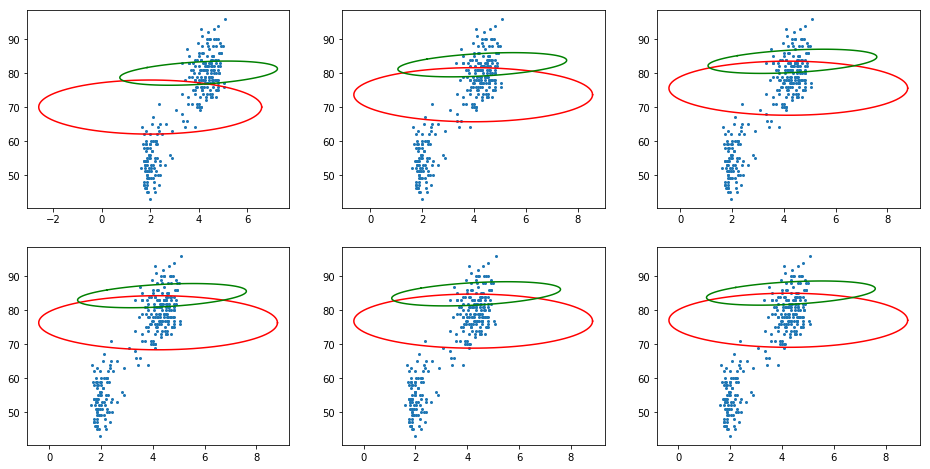

In [6]:
from gmmlib import expectation, maximization, maximization_mean

# make a true copy of our model
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization_mean(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)